### Basic MLP example with synapgrad

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from synapgrad.nn.utils.data import split_dataset, DataLoader, DataLoaderCallback
from synapgrad.nn.utils.train import Trainer, Evaluator

In [3]:
supported_engines = ['synapgrad', 'torch']

In [4]:
seed = 42
engine_str = 'synapgrad'

In [5]:
epochs = 50
batch_size = 4
lr = 0.1

In [6]:
if engine_str == 'synapgrad':
    import synapgrad as engine
    from synapgrad import nn
    from synapgrad import optim
elif engine_str == 'torch':
    import torch as engine
    from torch import nn
    from torch import optim
engine.manual_seed(seed)
print("Engine:", engine_str)

Engine: synapgrad


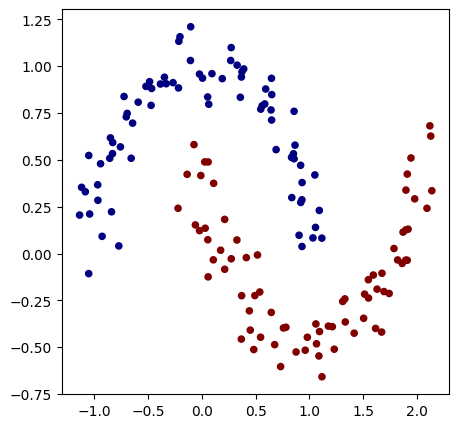

In [7]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=150, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
y = np.where(y > 0, 1, 0).tolist() # 0 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [8]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x:engine.Tensor):
        out = self.mlp(x)
        
        return out

model = MultiLayerPerceptron()
print("MLP Model:", model)
print("MLP Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MLP Model: MultiLayerPerceptron(submodules=1, parameters=337, trainable=337, non_trainable=0)
MLP Trainable Parameters: 337


In [9]:
class Transform(DataLoaderCallback):
    
    def __call__(self, data_loader:'DataLoader', X_batch:np.ndarray, y_batch:np.ndarray):
        x = engine.tensor(X_batch)
        y = engine.tensor(y_batch)
        return x, y
    
transform_cb = Transform()

split = False
if split:
    train, val, _ = split_dataset(X, y, test_split=0.2, shuffle=True)
    print("Train samples:", len(train), "| Val samples:", len(val))
    train_loader = DataLoader(train[0], train[1], batch_size, transform=transform_cb)
    val_loader = DataLoader(val[0], val[1], len(val[0]), transform=transform_cb) # 1 batch of all val samples
    print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))
else:
    train_loader = DataLoader(np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), batch_size, transform=transform_cb)
    print("Train batches:", len(train_loader))

Train batches: 37


In [10]:
loss_fn = nn.MSELoss() # nn.BCEWithLogitsLoss() could be used as well
optimizer = optim.SGD(model.parameters(), lr=lr)

trainer = Trainer(model, engine)
evaluator = Evaluator(accuracy=True, mode=Evaluator.BINARY)
trainer.compile(loss_fn, optimizer, evaluator)
history = trainer.fit(train_loader, epochs=epochs, validation_loader=None if not split else val_loader)

Epoch: 1/50
37/37 [================================] - 0s 2ms/step - loss: 0.1359 - accuracy: 0.8053  
Epoch: 2/50
37/37 [================================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.8610  
Epoch: 3/50
37/37 [================================] - 0s 1ms/step - loss: 0.0876 - accuracy: 0.8818    
Epoch: 4/50
37/37 [================================] - 0s 1ms/step - loss: 0.0816 - accuracy: 0.8888    
Epoch: 5/50
37/37 [================================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.9096    
Epoch: 6/50
37/37 [================================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9165  
Epoch: 7/50
37/37 [================================] - 0s 1ms/step - loss: 0.0558 - accuracy: 0.9304  
Epoch: 8/50
37/37 [================================] - 0s 1ms/step - loss: 0.0485 - accuracy: 0.9443    
Epoch: 9/50
37/37 [================================] - 0s 1ms/step - loss: 0.0414 - accuracy: 0.9651  
Epoch: 10/50
37/37 [================================] - 0s 1ms/st

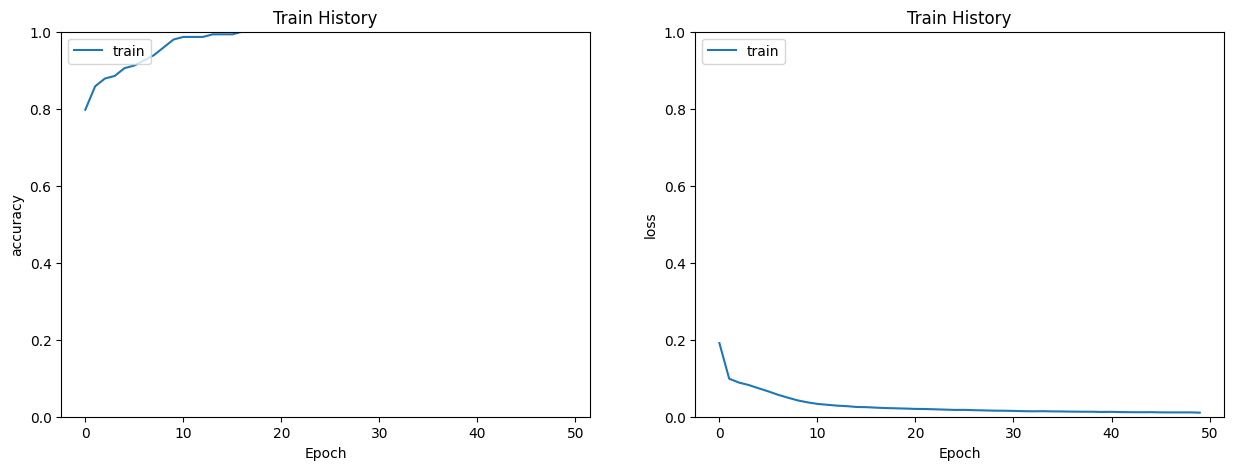

In [11]:
trainer.plot(['accuracy', 'loss'])

(-1.657620219259979, 2.0923797807400213)

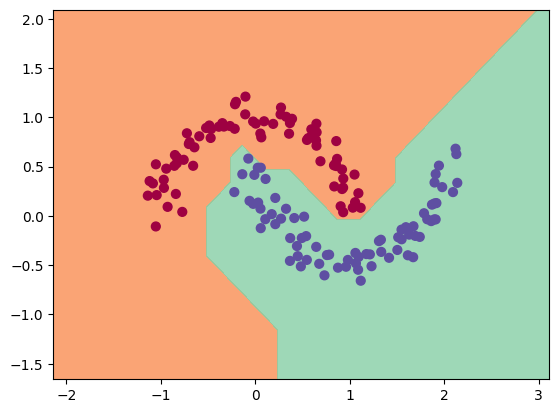

In [12]:
# visualize decision boundary
model.eval()
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = (np.c_[xx.ravel(), yy.ravel()]).astype(np.float32)

inputs = engine.tensor(Xmesh)
scores = model(inputs)
Z = np.array([s.detach().numpy() > 0.5 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())